In [2]:
from sklearn import tree, naive_bayes
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

pd.options.display.float_format = "{:.2f}".format
df = pd.read_csv('flow.csv', header=None)
df.columns = ['src_ip', 'dst_ip', 'src_port', 'dst_port', 'cli_pkt_count', 'cli_bytes',\
    'avg_cli_pkt_size', 'srv_pkt_count', 'srv_bytes', 'avg_srv_pkt_size', 'flow_duration', 'app_protocol']
df

,src_ip,dst_ip,src_port,dst_port,cli_pkt_count,cli_bytes,avg_cli_pkt_size,srv_pkt_count,srv_bytes,avg_srv_pkt_size,flow_duration,app_protocol
0,10.31.128.189,23.41.250.16,61102,443,2,608,304.00,2,223,111.50,20.13,http/1.1
1,10.31.128.189,23.41.250.16,61086,443,2,608,304.00,2,223,111.50,20.21,http/1.1
2,10.31.128.189,198.11.132.221,61111,443,6,1940,323.33,4,574,143.50,0.20,h2
3,10.31.128.189,151.101.126.109,61074,443,2,608,304.00,3,272,90.67,16.71,h2
4,10.31.128.189,151.101.126.109,61075,443,2,608,304.00,3,272,90.67,16.69,h2
...,...,...,...,...,...,...,...,...,...,...,...,...
7940,10.7.1.132,23.219.232.231,57990,443,5,3378,675.60,5,2256,451.20,5.07,http/1.1
7941,10.7.1.132,23.219.232.231,57991,443,4,2458,614.50,4,1573,393.25,5.06,http/1.1
7942,10.7.1.132,39.97.2.238,58251,443,10,3963,396.30,8,1839,229.88,4.24,http/1.1
7943,10.7.1.132,39.97.2.238,58250,443,5,903,180.60,1,176,176.00,13.96,http/1.1


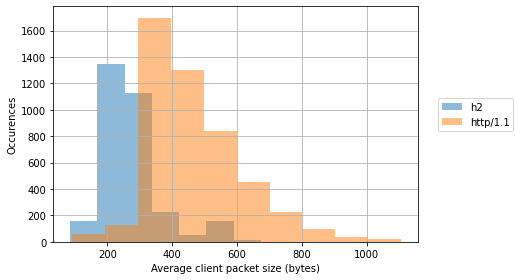

In [53]:
fig, ax = plt.subplots()
df.groupby("app_protocol").avg_cli_pkt_size.hist(alpha=0.5, ax=ax)
ax.set_xlabel('Average client packet size (bytes)')
ax.set_ylabel('Occurences')
fig.legend(('h2', 'http/1.1'), bbox_to_anchor=(1.2, 0.65))
fig.set_tight_layout(True)

In [29]:
(df['app_protocol']).value_counts()

http/1.1    4869
h2          3076
Name: app_protocol, dtype: int64

In [30]:
features = ['cli_pkt_count', 'cli_bytes', 'avg_cli_pkt_size', 'srv_pkt_count', 'srv_bytes', 'avg_srv_pkt_size', 'flow_duration']

In [31]:
h1 = df[df['app_protocol'] == 'http/1.1']
h1_stats = pd.DataFrame()
h1_stats['mean'] = h1[features].mean()
h1_stats['variance'] = h1[features].var()
h1_stats['std'] = h1[features].std()
h1_stats

,mean,variance,std
cli_pkt_count,7.37,4517.75,67.21
cli_bytes,2394.49,82134911.69,9062.83
avg_cli_pkt_size,457.87,24373.89,156.12
srv_pkt_count,6.86,4037.07,63.54
srv_bytes,1945.72,86779536.38,9315.55
avg_srv_pkt_size,325.41,50400.45,224.50
flow_duration,115.02,1288909.34,1135.30


In [32]:
h2 = df[df['app_protocol'] == 'h2']
h2_stats = pd.DataFrame()
h2_stats['mean'] = h2[features].mean()
h2_stats['variance'] = h2[features].var()
h2_stats['std'] = h2[features].std()
h2_stats

,mean,variance,std
cli_pkt_count,7.94,267.87,16.37
cli_bytes,1952.57,24373627.90,4936.97
avg_cli_pkt_size,275.60,8154.86,90.30
srv_pkt_count,12.18,2128.13,46.13
srv_bytes,8483.50,2677483245.23,51744.40
avg_srv_pkt_size,289.97,76523.25,276.63
flow_duration,71.37,30731.64,175.30


In [33]:
speed_test_data = df[features].sample(100000, replace=True).to_numpy()

def classification_speed_test(clf, data):
    start_time = time.time()
    for x in data:
        y = clf.predict([x])
    print("--- %s seconds ---" % (time.time() - start_time))

In [34]:
# Augment minority data (h2)

balanced = pd.concat([h1, h2, h2.sample(n=len(h1)-len(h2), replace=True, random_state=76)])

X = balanced[features].to_numpy()
Y = balanced['app_protocol'].to_numpy()
Y = np.array([1 if y == 'h2' else 0 for y in Y])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

accuracy: 0.6160547604231488
precision 0.5676100628930818
recall 0.9150823827629911


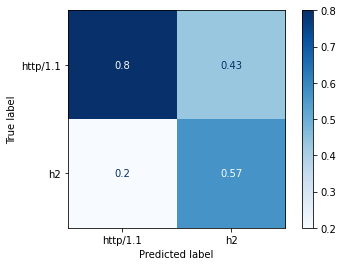

In [43]:
# Naive Bayes
clf = naive_bayes.GaussianNB([.5, .5])
clf = clf.fit(X_train, Y_train)
cm = confusion_matrix(Y_test, [clf.predict([x]) == Y_test[i] for i, x in enumerate(X_test)])
disp = plot_confusion_matrix(clf, X_test, Y_test, normalize='pred', display_labels=['http/1.1', 'h2'], cmap=plt.cm.Blues)
print('accuracy:', cm[:,1].sum() / len(Y_test))
print('precision', precision_score(Y_test, [clf.predict([x]) for x in X_test], labels=[0,1]))
print('recall', recall_score(Y_test, [clf.predict([x]) for x in X_test], labels=[0,1]))
# classification_speed_test(clf, speed_test_data)

number_of nodes: 201
number_of leaves: 101
accuracy 0.9894212818917237
precision 0.9910941475826972
recall 0.9873257287705957


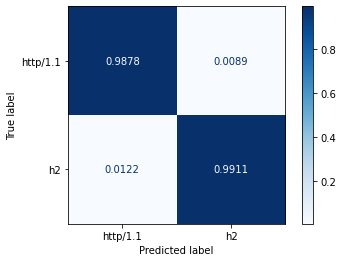

In [36]:
# Decision Tree
clf = tree.DecisionTreeClassifier(random_state=16)
clf.fit(X_train, Y_train)
print('number_of nodes:', clf.tree_.node_count)
print('number_of leaves:', clf.tree_.n_leaves)
cm = confusion_matrix(Y_test, [clf.predict([x]) == Y_test[i] for i, x in enumerate(X_test)])
disp = plot_confusion_matrix(clf, X_test, Y_test, normalize='pred', display_labels=['http/1.1', 'h2'], cmap=plt.cm.Blues, values_format='.4f')
print('accuracy', cm[:,1].sum() / len(Y_test))
print('precision', precision_score(Y_test, [clf.predict([x]) for x in X_test]))
print('recall', recall_score(Y_test, [clf.predict([x]) for x in X_test]))
# classification_speed_test(clf, speed_test_data)

accuracy: 0.8845675171126323
precision 0.9074949358541526
recall 0.8517110266159695
--- 6.899527311325073 seconds ---


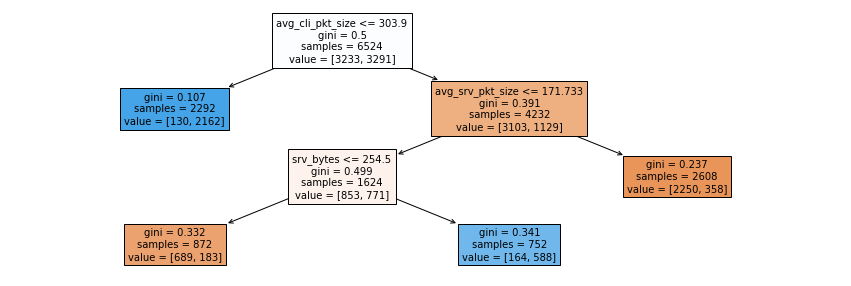

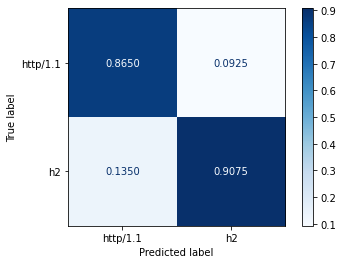

In [37]:
clf = tree.DecisionTreeClassifier(random_state=16, max_leaf_nodes=4)
clf = clf.fit(X_train, Y_train)
fig, ax = plt.subplots(figsize=(15, 5))
tree.plot_tree(clf, feature_names=features, fontsize=10, filled=True)
cm = confusion_matrix(Y_test, [clf.predict([x]) == Y_test[i] for i, x in enumerate(X_test)])
disp = plot_confusion_matrix(clf, X_test, Y_test, normalize='pred', display_labels=['http/1.1', 'h2'], cmap=plt.cm.Blues, values_format='.4f')
print('accuracy:', cm[:,1].sum() / len(Y_test))
print('precision', precision_score(Y_test, [clf.predict([x]) for x in X_test]))
print('recall', recall_score(Y_test, [clf.predict([x]) for x in X_test]))
classification_speed_test(clf, speed_test_data)

accuracy: 0.9735532047293093
precision 0.9721695129664769
recall 0.9740177439797212


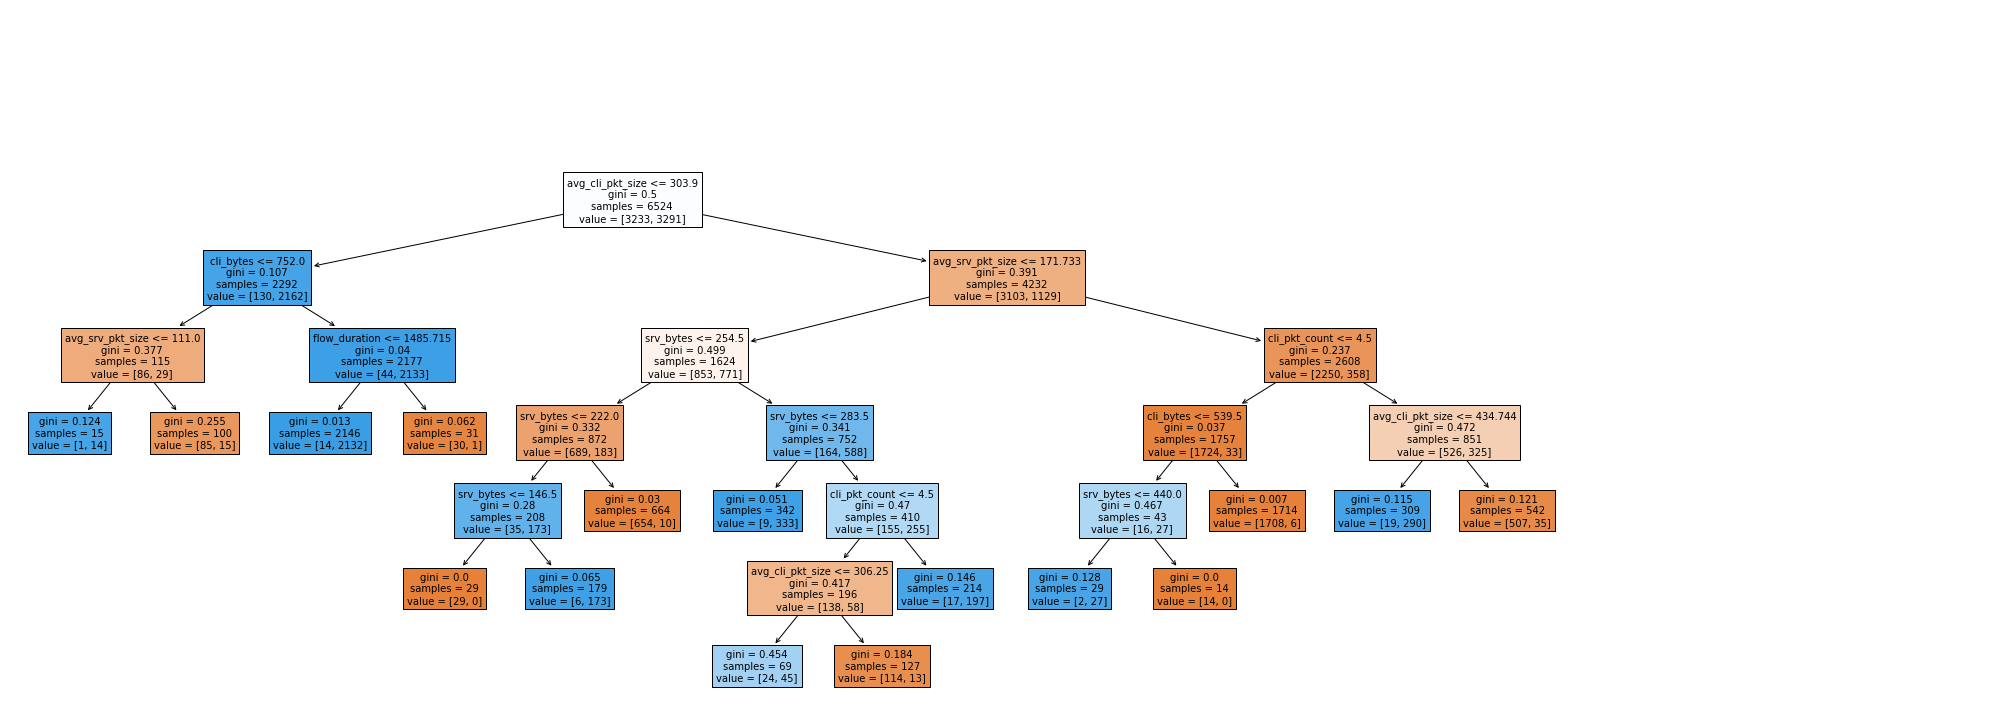

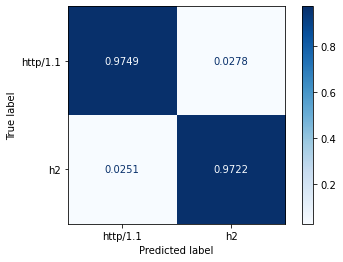

In [38]:
clf = tree.DecisionTreeClassifier(random_state=17, max_leaf_nodes=16)
clf = clf.fit(X_train, Y_train)
fig, ax = plt.subplots(figsize=(28, 10))
fig.set_tight_layout(True)
tree.plot_tree(clf, feature_names=features, fontsize=10, filled=True)
cm = confusion_matrix(Y_test, [clf.predict([x]) == Y_test[i] for i, x in enumerate(X_test)])
disp = plot_confusion_matrix(clf, X_test, Y_test, normalize='pred', display_labels=['http/1.1', 'h2'], cmap=plt.cm.Blues, values_format='.4f')
print('accuracy:', cm[:,1].sum() / len(Y_test))
print('precision', precision_score(Y_test, [clf.predict([x]) for x in X_test]))
print('recall', recall_score(Y_test, [clf.predict([x]) for x in X_test]))
# classification_speed_test(clf, speed_test_data)

# 新段落

accuracy: 0.9906658369632856
precision 0.9892541087231352
recall 0.9917617237008872


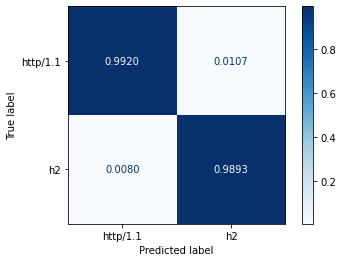

In [39]:
# Random Forest
clf = RandomForestClassifier(n_estimators=15, random_state=16)
clf = clf.fit(X_train, Y_train)
cm = confusion_matrix(Y_test, [clf.predict([x]) == Y_test[i] for i, x in enumerate(X_test)])
disp = plot_confusion_matrix(clf, X_test, Y_test, normalize='pred', display_labels=['http/1.1', 'h2'], cmap=plt.cm.Blues, values_format='.4f')
print('accuracy:', cm[:,1].sum() / len(Y_test))
print('precision', precision_score(Y_test, [clf.predict([x]) for x in X_test]))
print('recall', recall_score(Y_test, [clf.predict([x]) for x in X_test]))
# classification_speed_test(clf, speed_test_data)

accuracy: 0.9934660858743
precision 0.9936588459099556
recall 0.9930291508238276


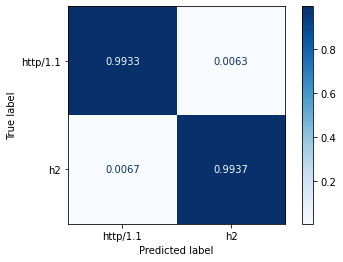

In [40]:
# Ada Boost (Decision Tree)
clf = AdaBoostClassifier(n_estimators=15, base_estimator=tree.DecisionTreeClassifier(max_leaf_nodes=32), random_state=87)
clf = clf.fit(X_train, Y_train)
cm = confusion_matrix(Y_test, [clf.predict([x]) == Y_test[i] for i, x in enumerate(X_test)])
disp = plot_confusion_matrix(clf, X_test, Y_test, normalize='pred', display_labels=['http/1.1', 'h2'], cmap=plt.cm.Blues, values_format='.4f')
print('accuracy:', cm[:,1].sum() / len(Y_test))
print('precision', precision_score(Y_test, [clf.predict([x]) for x in X_test]))
print('recall', recall_score(Y_test, [clf.predict([x]) for x in X_test]))
# classification_speed_test(clf, speed_test_data)